In [60]:
#+.+
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter
import re

In [6]:
#Load and clean
data=pd.read_csv('headlines_with_returns.csv')
data.head()
data=data.drop(columns=['Time/Date', 'Tickers']) #drop first two columns
data=data.dropna(subset=['return']) #drop rows with no return value
data.head()

,Headlines,ticker,date,return
0,CytoDyn to update investors on regulatory and...,CYDY,2020-08-28 04:46:00,-0.023256
1,Apple terminates Epic Games' developer account,AAPL,2020-08-28 04:41:00,0.033912
3,"Legend Biotech EPS misses by $0.42, misses on...",LEGN,2020-08-28 04:38:00,0.000000
4,Denmark's AAA rating affirmed by S&P as fisca...,EDEN,2020-08-28 04:37:00,0.000596
6,BNY Mellon Strategic Municipals declares $0.0...,LEO,2020-08-28 04:27:00,0.008516


General Exploration

There are  3851  unique tickers.
The most common tickers featured are: 

AAPL: 70
AMZN: 60
TSLA: 44
MSFT: 41
BA: 36
GOOG: 35
AZN: 34
DIS: 34
MRNA: 27
XOM: 25
DKNG: 25
CVX: 24
T: 23
PFE: 23
WFC: 22
GILD: 21
WMT: 21
XLF: 20
UBER: 20
AAL: 20
RHHBY: 20
XLE: 19
GS: 19
GM: 18
VZ: 18
AMC: 17
JPM: 17
USO: 17
NFLX: 17
JNJ: 17
KODK: 17
MCD: 16
FMCC: 16
NIO: 15
CCL: 15
BP: 15
BABA: 15
RIO: 15
BX: 15
F: 14
HD: 14
ZM: 14
LLY: 14
SPY: 14
GOLD: 14
NVDA: 14
ROKU: 14
SNY: 14
BLNK: 13
NVAX: 13
FCX: 13
FXI: 13
SPCE: 13
DAL: 13
MPC: 13
C: 13
CRM: 13
AMD: 13
ABBV: 13
INTC: 13
MGM: 13
PCG: 13
TLT: 13
CYDY: 13
BAC: 12
COM: 12
ITB: 12
UAL: 12
MRK: 12
MARA: 12
TYL: 12
SRNE: 12
NAK: 12
TGT: 12
GE: 12
ET: 12
TEVA: 12
BLK: 11
EBAY: 11
W: 11
CMCSA: 11
PBR: 11
BMY: 11
CSCO: 11
VALE: 11
FNMA: 11
TMO: 11
AA: 11
SPG: 11
BHP: 11
TLSA: 10
ATUS: 10
VWAGY: 10
HAL: 10
BAESY: 10
ABT: 10
HOG: 10
RCL: 10
LMT: 10
BOXL: 10
FL: 10
DKS: 10
TTWO: 10
PLUG: 10
FSLY: 10
ALTO: 10
TSM: 10
DPZ: 9
QCOM: 9
RIG: 9
RDHL: 9
PANW: 9
BHC: 9
NK

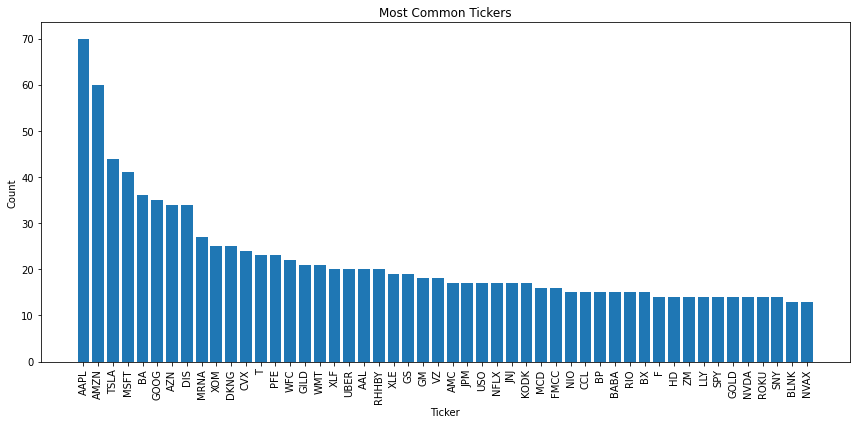

In [7]:
#How many different companies? 
unique_tickers=data['ticker'].unique() #get unique tickers (company names)
print("There are ", len(unique_tickers), " unique tickers.")
ticker_counts=data['ticker'].value_counts()
print("The most common tickers featured are: \n")
for ticker, count in ticker_counts.items(): 
    print(f"{ticker}: {count}")

#visualize
ticker_counts=data['ticker'].value_counts().head(50)
plt.figure(figsize=(12,6))
plt.bar(ticker_counts.index,ticker_counts.values)
plt.title('Most Common Tickers')
plt.xlabel('Ticker')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

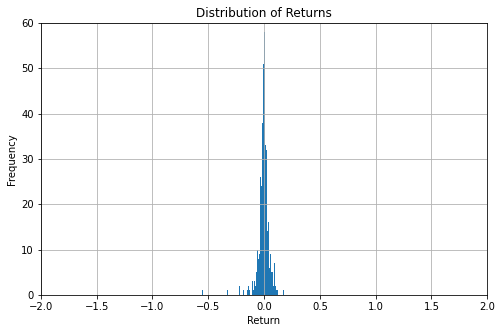

In [8]:
#Overall returns distribution
plt.figure(figsize=(8,5))
plt.hist(data['return'],bins=1000000)
plt.xlim(-2,2)
plt.ylim(0,60)
plt.title('Distribution of Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
#Seems to be centered around 0 (as expected, no bias involved)
#Doesn't seem to be many large outliers 

In [23]:
#double check for large outliers
print(data['return'].describe())
#maximum value is highly suspicious, investigate 
max_return=data['return'].max()
max_return_row=data[data['return']==max_return]

print("\nMaximum return value row: ", max_return_row) #clearly, this return is basically impossible, likely will need to remove it
#check for more outliers

outliers = data[abs(data['return']) > 5] #check for outliers representing more than %500 change
print(f"\nNumber of return outliers > 5 or < -5: {len(outliers)}")
print(outliers)

mean=data['return'].mean()
std=data['return'].std()
z_threshold=3 

outliers_z=data[(data['return']-mean).abs()>z_threshold*std] #check outliers using z-scores
print(f"\nNumber of outliers beyond {z_threshold} standard deviations: {len(outliers_z)}")
print(outliers_z)

print("\nLooks like the maximum value is WAY beyond the rest of the data, and all other return values are within -5 and 5, or within 3 standard deviations of the mean. Let's remove it.")
data=data[data['return'] != max_return] #remove this huge outlier
print("Max return after removal: ", data['return'].max())

count    10791.000000
mean         0.031748
std          2.948606
min         -0.581818
25%         -0.019647
50%          0.000000
75%          0.019758
max        306.142911
Name: return, dtype: float64

Maximum return value row:                                           Headlines ticker  \
7736   Banco de Sabadell, S.A. reports 1H results   BNDSF   

                     date      return  direction  
7736  2020-07-31 07:35:00  306.142911          1  

Number of return outliers > 5 or < -5: 1
                                         Headlines ticker  \
7736   Banco de Sabadell, S.A. reports 1H results   BNDSF   

                     date      return  direction  
7736  2020-07-31 07:35:00  306.142911          1  

Number of outliers beyond 3 standard deviations: 1
                                         Headlines ticker  \
7736   Banco de Sabadell, S.A. reports 1H results   BNDSF   

                     date      return  direction  
7736  2020-07-31 07:35:00  306.142911          1 

In [24]:
#Convert target (return) to classification (up/down)
data['direction']=data['return'].apply(lambda x: 1 if x > 0 else 0)
data.to_csv('headlines_with_returns_directions.csv')
data.head()

,Headlines,ticker,date,return,direction
0,CytoDyn to update investors on regulatory and...,CYDY,2020-08-28 04:46:00,-0.023256,0
1,Apple terminates Epic Games' developer account,AAPL,2020-08-28 04:41:00,0.033912,1
3,"Legend Biotech EPS misses by $0.42, misses on...",LEGN,2020-08-28 04:38:00,0.000000,0
4,Denmark's AAA rating affirmed by S&P as fisca...,EDEN,2020-08-28 04:37:00,0.000596,1
6,BNY Mellon Strategic Municipals declares $0.0...,LEO,2020-08-28 04:27:00,0.008516,1



Number of rows with return > 0:  5074

Number of rows with return exactly equal 0:  466

Number of rows with return < 0:  5250


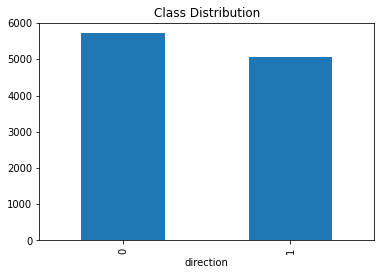

In [25]:
#Getting a general idea of directions
data['direction'].value_counts().plot(kind='bar',title='Class Distribution')
print('\nNumber of rows with return > 0: ', (data['return']>0).sum())
print('\nNumber of rows with return exactly equal 0: ', (data['return']==0).sum())
print('\nNumber of rows with return < 0: ', (data['return']<0).sum())

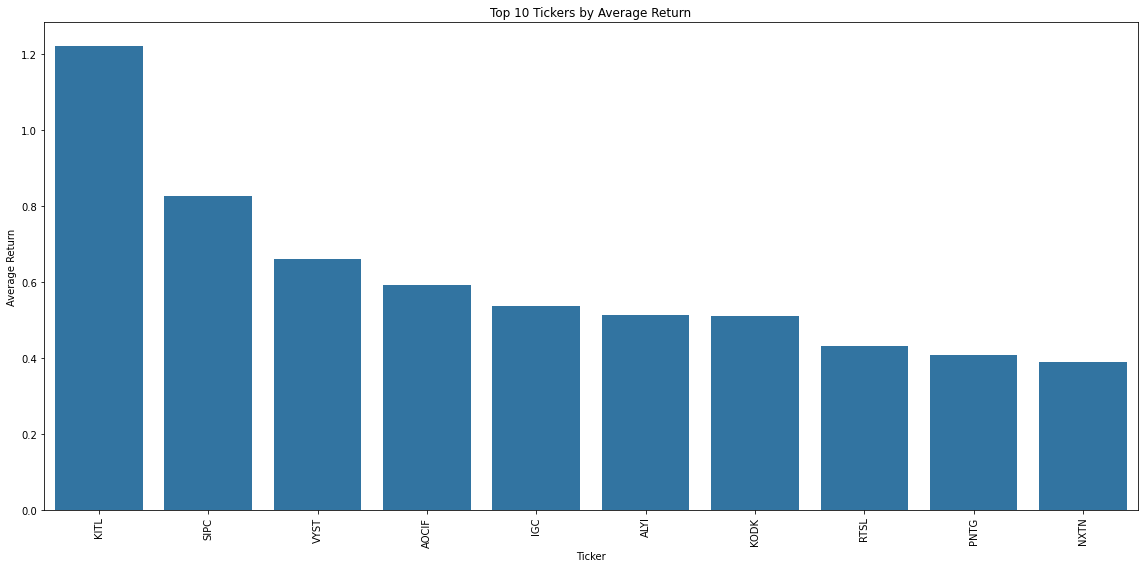

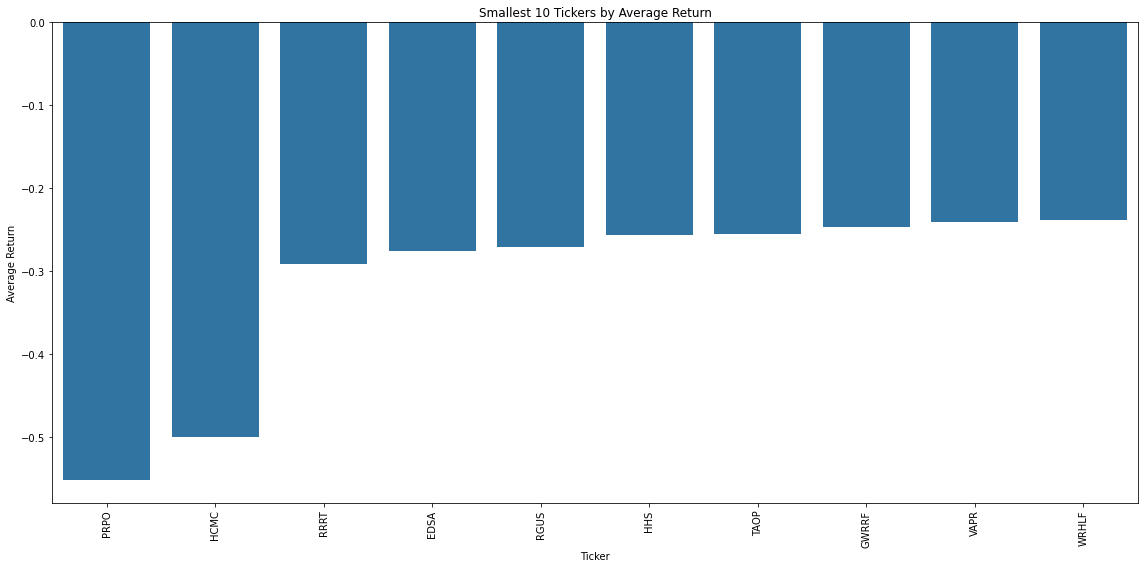

In [29]:
#Average returns per ticker
avg_return_per_ticker=data.groupby(['ticker'])['return'].mean()
avg_return_per_ticker=avg_return_per_ticker.sort_values(ascending=False)
top100avgperticker=avg_return_per_ticker.head(10)
avg_return_per_tickerdesc=avg_return_per_ticker.sort_values(ascending=True)
top100avgpertickerdesc=avg_return_per_tickerdesc.head(10)

plt.figure(figsize=(16, 8))
sns.barplot(x=top100avgperticker.index,y=top100avgperticker.values)
plt.xticks(rotation=90)
plt.title('Top 10 Tickers by Average Return')
plt.xlabel('Ticker')
plt.ylabel('Average Return')
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 8))
sns.barplot(x=top100avgpertickerdesc.index,y=top100avgpertickerdesc.values)
plt.xticks(rotation=90)
plt.title('Smallest 10 Tickers by Average Return')
plt.xlabel('Ticker')
plt.ylabel('Average Return')
plt.tight_layout()
plt.show()



In [55]:
#Average return per month
data['date']=pd.to_datetime(data['date'])
monthly_avg_return=data.set_index('date').groupby(pd.Grouper(freq='M'))['return'].mean().reset_index()
monthly_avg_return.head()

,date,return
0,2020-07-31,0.005031
1,2020-08-31,0.001884


In [42]:
#Average return per day of the week
weekday_avg_return=data.groupby(data['date'].dt.day_name())['return'].mean().reset_index()
weekday_avg_return.head(12)

,date,return
0,Friday,0.006372
1,Monday,-0.004546
2,Saturday,-0.007736
3,Sunday,-0.002240
4,Thursday,0.002880
5,Tuesday,0.014516
6,Wednesday,-0.001850


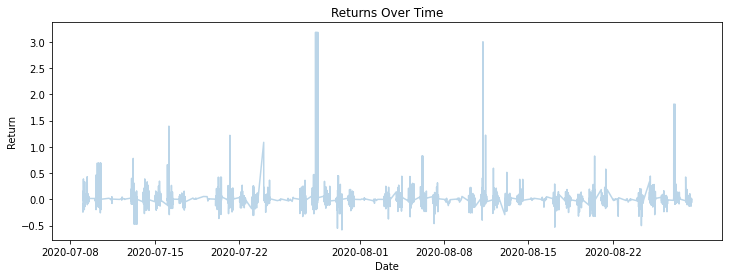

In [57]:
#return vs. date
data['date']=pd.to_datetime(data['date'])
data.sort_values('date',inplace=True)
plt.figure(figsize=(12, 4))
plt.plot(data['date'],data['return'],alpha=0.3)
plt.title('Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Return')
plt.show()

In [61]:
#what words are most common? 
def tokenize(text): #function to split text into lowercase word tokens
    return re.findall(r'\b\w+\b',text.lower())

all_words=data['Headlines'].dropna().apply(tokenize).sum() #flatten all tokens
word_counts=Counter(all_words)

#top 20 most common
common_words=word_counts.most_common(20)
print("The most common words are: ")
for word,count in common_words: 
    print(f"{word}: {count}")

The most common words are: 
on: 3081
beats: 2964
0: 2663
by: 2219
revenue: 2181
eps: 2008
to: 1445
in: 1298
misses: 1172
q2: 1146
s: 1046
dividend: 938
for: 928
results: 829
reports: 811
declares: 760
of: 745
after: 708
and: 576
as: 522


Feature Engineering

In [48]:
analyzer=SentimentIntensityAnalyzer()
data['compound_sentiment']=data['Headlines'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
data.head()

,Headlines,ticker,date,return,direction,compound_sentiment
0,CytoDyn to update investors on regulatory and...,CYDY,2020-08-28 04:46:00,-0.023256,0,0.0000
1,Apple terminates Epic Games' developer account,AAPL,2020-08-28 04:41:00,0.033912,1,0.0000
3,"Legend Biotech EPS misses by $0.42, misses on...",LEGN,2020-08-28 04:38:00,0.000000,0,-0.4215
4,Denmark's AAA rating affirmed by S&P as fisca...,EDEN,2020-08-28 04:37:00,0.000596,1,-0.3818
6,BNY Mellon Strategic Municipals declares $0.0...,LEO,2020-08-28 04:27:00,0.008516,1,0.0000


The 'compound sentiment' here from VADER summarizes the overall sentiment (positive sentiment is positive numerically, negative sentiment is negative numerically, 0 is neutral).

In [50]:
#Adding headline length & word count
data['headline_length']=data['Headlines'].apply(len)
data['word_count']=data['Headlines'].apply(lambda x: len(x.split()))
data.head()

,Headlines,ticker,date,return,direction,compound_sentiment,headline_length,word_count
0,CytoDyn to update investors on regulatory and...,CYDY,2020-08-28 04:46:00,-0.023256,0,0.0000,79,11
1,Apple terminates Epic Games' developer account,AAPL,2020-08-28 04:41:00,0.033912,1,0.0000,48,6
3,"Legend Biotech EPS misses by $0.42, misses on...",LEGN,2020-08-28 04:38:00,0.000000,0,-0.4215,55,9
4,Denmark's AAA rating affirmed by S&P as fisca...,EDEN,2020-08-28 04:37:00,0.000596,1,-0.3818,79,13
6,BNY Mellon Strategic Municipals declares $0.0...,LEO,2020-08-28 04:27:00,0.008516,1,0.0000,58,7


In [53]:
#Adding date based features
data['day_of_week']=data['date'].dt.dayofweek #Monday=0, Sunday=6
data['month']=data['date'].dt.month
data.head()

,Headlines,ticker,date,return,direction,compound_sentiment,headline_length,word_count,day_of_week,month,year
0,CytoDyn to update investors on regulatory and...,CYDY,2020-08-28 04:46:00,-0.023256,0,0.0000,79,11,4,8,2020
1,Apple terminates Epic Games' developer account,AAPL,2020-08-28 04:41:00,0.033912,1,0.0000,48,6,4,8,2020
3,"Legend Biotech EPS misses by $0.42, misses on...",LEGN,2020-08-28 04:38:00,0.000000,0,-0.4215,55,9,4,8,2020
4,Denmark's AAA rating affirmed by S&P as fisca...,EDEN,2020-08-28 04:37:00,0.000596,1,-0.3818,79,13,4,8,2020
6,BNY Mellon Strategic Municipals declares $0.0...,LEO,2020-08-28 04:27:00,0.008516,1,0.0000,58,7,4,8,2020


In [56]:
data.to_csv('headlinesNLPdata.csv')